<h2>Diamond Price Prediction</h2>

<h3>1. Introduction</h3>

<div class="alert alert-block alert-info">
In this analysis, we will be looking at predicting the price of diamonds from a dataset which has multiple features, numerical and categorical. The process will be the following:
<li>The dataset will be split in 3 parts: a partition will be set aside for testing, and the remaining part will be further split in 2 partitions: one for training and one for validation. </li>
<li>We will use tensorflow.keras, attempt combinations of these features to see which one has the highest predictive power. </li>
<li>Once we have decided on the set of features to use, we will be adjusting parameters to improve the model. </li>
<li>When a combination of parameters has also been found to work the best, we will run the model for more iterations (epochs) to see where the learning stops. </li>
<li>The final selection of parameters, including the number of epochs will then be trained on the (train + validation) partition and evaluated on the testing partition.</li>
</div>

<h3>2. Methodology</h3>

<div class="alert alert-block alert-info">
We start by importing all the dependendies required for this analysis. This includes os, tensorflow, pandas, matplotlib and scikit-learn.
</div>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import feature_column
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy.random import seed
from IPython.display import Markdown as md

In [2]:
# Configuration specific to Apple Mac M1. 
# Turn off GPU as it is actually slower than CPU for learning models which are not complex enough to benefit from parallel processing
# https://stackoverflow.com/questions/70653251/why-gpu-is-3-5-times-slower-than-the-cpu-on-apple-m1-mac
tf.config.set_visible_devices([], 'GPU')

<div class="alert alert-block alert-info">
Add random setting for reproducible results:
</div>

In [3]:
# set numpy random seed
seed(99)
# set tensorflow random seed - setting from https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/random/set_seed
tf.random.set_seed(100)

In [4]:
# turn off notebook warnings but keep errors
# https://www.codegrepper.com/code-examples/python/keras+disable+tensorflow+warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# setting to ignore warnings from https://softhints.com/turn-off-warnings-jupyterlab-jupyter-notebook/
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
We then read the dataset from a CSV file into a pandas dataframe.
</div>

In [6]:
# data source: https://www.kaggle.com/datasets/shivam2503/diamonds?resource=download
ds = pd.read_csv('diamonds.csv', header=0)

<div class="alert alert-block alert-info">
Let's what types of columns we have in the dataframe:
</div>

In [7]:
ds.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

<div class="alert alert-block alert-info">
And what the values look like:
</div>

In [8]:
ds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


<div class="alert alert-block alert-info">
We notice that the index column is being duplicated as it was already included in the CSV file. Let's remove this column from the dataframe.
</div>

In [9]:
ds = ds.drop(columns=['Unnamed: 0'])

<div class="alert alert-block alert-info">
Based on the types of the columns, we will first separate the numerical features, excluding the <b>price</b>, which is our target variable.
</div>

In [10]:
labels_numerical = ['carat','depth','table', 'x', 'y', 'z']
labels_categorical = ['cut', 'color','clarity']
labels_all = ['carat','depth','table', 'x', 'y', 'z', 'cut', 'color', 'clarity']

<div class="alert alert-block alert-info">
Let's verify that we have made a correct selection so far:
</div>

In [11]:
ds[labels_numerical].head()

,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75


<div class="alert alert-block alert-info">
Now, we will split the data now into 2 parts: one for training and validation and one for testing. We will retain <b>30%</b> of the data for testing.
</div>

In [12]:
# using random state_setting to have reproducible results
train_val_data, test_data = train_test_split(ds, test_size=0.3, random_state=99, shuffle=True)

<div class="alert alert-block alert-info">
Now, the partition that we kept for training and validation will be further split in 2 parts: one for training and one for validation. We will use <b>20%</b> of the data to validate the model.
</div>

In [13]:
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=99, shuffle=True)

<div class="alert alert-block alert-info">
Let'see how many records we have now for each of the 3 partitions:
</div>

In [14]:
print("records for training: ", len(train_data))
print("records for validation: ", len(val_data))
print("records for testing: ",len(test_data))

records for training:  30206
records for validation:  7552
records for testing:  16182


<div class="alert alert-block alert-info">
Now we will extract the average price of a diamond in the training dataset. Notice that we are <b>excluding the test partition</b>, which should be completely "invisible" to us while we select and improve the model. While there is likely little "spillover" in the mean of the data, this is the correct way to approach it.
</div>

In [15]:
avg_price = train_val_data['price'].mean()
print(avg_price)

3930.7659039144023


<div class="alert alert-block alert-info">
It is typical to normalize numerical values so let us build a function for this purpose.
</div>

In [16]:
# function to normalize a numerical column
def normalize(dataset, mean_dict_input, std_dict_input, column):
    return (dataset[column] - mean_dict_input[column]) / std_dict_input[column]

<div class="alert alert-block alert-info">
Let's build 2 dictionaries to store the mean and standard deviation values from the training dataset
</div>

In [17]:
mean_dict = {}
std_dict = {}
for column in train_data[labels_numerical]:
    mean_dict[column] = train_data[column].mean()
    std_dict[column] = train_data[column].std()

<div class="alert alert-block alert-info">
And see what the results look like
</div>

In [18]:
print(mean_dict)
print(std_dict)

{'carat': 0.7967321062040654, 'depth': 61.74703701251407, 'table': 57.46264980467456, 'x': 5.731561610276104, 'y': 5.735978613520492, 'z': 3.539405416142489}
{'carat': 0.46916521420385654, 'depth': 1.4431027679374298, 'table': 2.2305768278461398, 'x': 1.1128890216320924, 'y': 1.1557189126276661, 'z': 0.7091887067583221}


<div class="alert alert-block alert-info">
We will now apply the <b>normalization</b> function to all the columns that have numerical values in both the training and the validation datasets. <br/>
    Notice that we take the mean and standard deviation <b>from the training dataset only</b> as we do not want to have information spillover from the other partitions. <br/>
The price doesn't need to be normalized as that will not influence the results and it will make the interpretation of the results more difficult.
</div>

In [19]:
# normalize data in train and validation partition using mean and standard deviation from the training partition
for column in labels_numerical:
    train_data[column] = normalize(train_data, mean_dict, std_dict, column)
    val_data[column] = normalize(val_data, mean_dict, std_dict, column)

In [20]:
train_data[labels_numerical].head()

,carat,depth,table,x,y,z
46714,-0.419324,-1.349202,1.989329,-0.253001,-0.204183,-0.379878
32412,-0.824298,-0.032594,-1.552356,-0.855037,-0.818520,-0.831098
19300,0.454569,-0.379070,0.240902,0.645562,0.652426,0.593064
43401,-0.440638,-0.032594,-0.207413,-0.306914,-0.264752,-0.281174
47934,-0.504582,-0.032594,-1.552356,-0.342857,-0.394541,-0.365778


<div class="alert alert-block alert-info">
We can see now that the standard deviation for all the fields is 1.00 and the mean is ~0 in the training dataset, which is as expected
</div>

In [21]:
train_data[labels_numerical].describe()

,carat,depth,table,x,y,z
count,3.020600e+04,3.020600e+04,3.020600e+04,3.020600e+04,3.020600e+04,3.020600e+04
mean,-3.246206e-17,-2.739280e-16,2.491581e-15,4.746988e-16,1.627808e-16,-8.066116e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.271902e+00,-1.299078e+01,-6.483816e+00,-5.150165e+00,-4.963126e+00,-4.990781e+00
25%,-8.456128e-01,-5.176603e-01,-6.557272e-01,-9.089510e-01,-8.704354e-01,-8.875006e-01
50%,-2.061792e-01,3.670077e-02,-2.074126e-01,-2.836007e-02,-1.382569e-02,-1.326222e-02
75%,5.185122e-01,5.217667e-01,6.892164e-01,7.174466e-01,6.870368e-01,6.917687e-01
max,7.104678e+00,1.140110e+01,8.310563e+00,3.853429e+00,4.600082e+01,3.984919e+01


<div class="alert alert-block alert-info">
However, we don't see the same results when we look at the validation data. The mean is still very close to 0 and the standard deviation close to 1 but there are some differences. This makes sense, because the mean and standard deviation we calculated did not consider anything from the validation dataset.
</div>

In [22]:
val_data[labels_numerical].describe()

,carat,depth,table,x,y,z
count,7552.000000,7552.000000,7552.000000,7552.000000,7552.000000,7552.000000
mean,0.008896,0.003108,0.000212,0.004949,0.002409,0.002821
std,1.028233,0.982008,0.994476,1.012843,0.968753,0.986661
min,-1.271902,-7.447174,-3.793929,-1.744614,-1.701087,-4.990781
25%,-0.845613,-0.448365,-0.655727,-0.908951,-0.879088,-0.887501
50%,-0.206179,0.036701,-0.207413,-0.028360,-0.022478,-0.013262
75%,0.518512,0.521767,0.689216,0.717447,0.687037,0.691769
max,8.980350,5.857492,9.655507,4.500393,4.156739,4.851451


<div class="alert alert-block alert-info">
We will now convert the dataset to a tensorflow dataset in order to make use of the <b>feature_columns</b> module in tensorflow. We will be using a function for this purpose, which we have imported from tensorflow.org documentation.
</div>

In [23]:
# source: https://www.tensorflow.org/tutorials/structured_data/feature_columns
# adapted the function and set batching after conversion by using smallLastBatch=True for batch method to avoid rank 0 error 
# https://stackoverflow.com/questions/48046504/tensorflow-linearregressor-feature-cannot-have-rank-0
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    target = dataframe.pop('price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), target))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size, False)
    return ds

<div class="alert alert-block alert-info">
Applying the function to each of the datasets
</div>

In [24]:
# convert dataframes to tensorflow datasets and apply batching with default value
train_ds = df_to_dataset(train_data, shuffle=False)
train_ds = train_ds.batch(32, False)
val_ds = df_to_dataset(val_data, shuffle=False)
val_ds = val_ds.batch(32, False)

<div class="alert alert-block alert-info">
Checking size before and after applying batch method
</div>

In [25]:
print(len(train_data))
print(len(train_ds))

30206
944


<div class="alert alert-block alert-info">
Let's see how the data look like in this new structure
</div>

In [26]:
# source: https://www.tensorflow.org/tutorials/structured_data/feature_columns
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of carats:', feature_batch['carat'])
    print('A batch of prices:', label_batch )

Every feature: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
A batch of carats: tf.Tensor(
[-0.41932373 -0.82429834  0.45456885 -0.44063818 -0.50458154 -0.5685249
  0.88085792 -0.80298388 -0.61115381  0.19879542  0.62508448  0.15616651
  0.24142432  0.22010987  1.58423487 -1.03744287  1.71212159 -0.52589599
  0.73165675  1.09400245 -0.84561279  0.45456885 -0.86692724  0.79560011
  0.02827979 -0.2061792  -1.05875732  0.22010987  1.92526612 -0.18486474
 -0.82429834  0.92348682], shape=(32,), dtype=float64)
A batch of prices: tf.Tensor(
[ 1793   791  8016  1412  1915  1607  8699   902  1634  2728  4670  4108
  3033  4198  7877   544  9229  1881  6144  8617   667  3897   698 10681
  3266  2184   945  3478 15259  2743   875 16253], shape=(32,), dtype=int64)


<div class="alert alert-block alert-info">
Let's initialize 3 separate lists which will store the feature columns. <br/>
We will store just the numerical columns in one, just the categorical columns in another and all of the feature columns in the last one. <br/>
This will allow us to analyze separately the predictive power of each of these combinations
</div>

In [27]:
feature_columns_numerical = []
feature_columns_categorical = []
feature_columns_all = []

<div class="alert alert-block alert-info">
All the numerical columns will now be converted to feature columns and will be added to the list containing numerical columns and the list containing all the columns.
</div>

In [28]:
for column in labels_numerical:
    feature_columns_numerical.append(feature_column.numeric_column(column))
    feature_columns_all.append(feature_column.numeric_column(column))

<div class="alert alert-block alert-info">
Let's have a look at the possible values for the categorical columns
</div>

In [29]:
print(train_data.cut.unique())
print(train_data.color.unique())
print(train_data.clarity.unique())

['Good' 'Ideal' 'Premium' 'Very Good' 'Fair']
['G' 'D' 'F' 'E' 'H' 'I' 'J']
['VS2' 'SI1' 'VVS2' 'VS1' 'SI2' 'VVS1' 'IF' 'I1']


<div class="alert alert-block alert-info">
And also the distribution of the values
</div>

<AxesSubplot:>

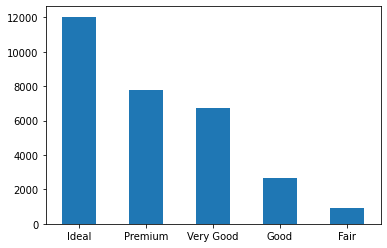

In [30]:
train_data['cut'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

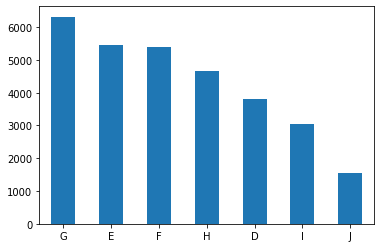

In [31]:
train_data['color'].value_counts().plot.bar(rot=0)

<AxesSubplot:>

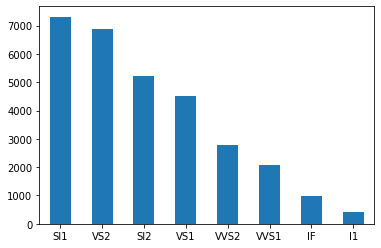

In [32]:
train_data['clarity'].value_counts().plot.bar(rot=0)

<div class="alert alert-block alert-info">
There doesn't seem to be any abnormality in the distribution of values but we do have many possible options for each. <br/>
We will now be using the <b>categorical_column_with_vocabulary_list</b> method to convert the categorical columns to indicator columns, which are numerical <br/>
</div>

In [33]:
# add indicator_columns to the lists of features
for column in labels_categorical:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(column, train_data[column].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns_categorical.append(indicator_column)
    feature_columns_all.append(indicator_column)

<div class="alert alert-block alert-info">
The values have now been added to all the 3 list. Let's verify what we have in each:
</div>

In [34]:
feature_columns_numerical

[NumericColumn(key='carat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='depth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='table', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='y', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='z', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [35]:
feature_columns_categorical

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='cut', vocabulary_list=('Good', 'Ideal', 'Premium', 'Very Good', 'Fair'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='color', vocabulary_list=('G', 'D', 'F', 'E', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='clarity', vocabulary_list=('VS2', 'SI1', 'VVS2', 'VS1', 'SI2', 'VVS1', 'IF', 'I1'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [36]:
feature_columns_all

[NumericColumn(key='carat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='depth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='table', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='y', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='z', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='cut', vocabulary_list=('Good', 'Ideal', 'Premium', 'Very Good', 'Fair'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='color', vocabulary_list=('G', 'D', 'F', 'E', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categoric

<div class="alert alert-block alert-info">
And see some samples from the numerical features and categorical features
</div>

In [37]:
# help from https://www.tensorflow.org/tutorials/structured_data/feature_columns
layers.DenseFeatures(feature_columns_numerical[0])(next(iter(train_ds))[0]).numpy()

array([[-0.4193237 ],
       [-0.8242983 ],
       [ 0.45456886],
       [-0.44063818],
       [-0.5045815 ],
       [-0.5685249 ],
       [ 0.88085794],
       [-0.8029839 ],
       [-0.6111538 ],
       [ 0.19879542],
       [ 0.62508446],
       [ 0.15616651],
       [ 0.24142432],
       [ 0.22010987],
       [ 1.5842348 ],
       [-1.0374429 ],
       [ 1.7121216 ],
       [-0.525896  ],
       [ 0.73165673],
       [ 1.0940025 ],
       [-0.84561276],
       [ 0.45456886],
       [-0.86692727],
       [ 0.7956001 ],
       [ 0.02827979],
       [-0.2061792 ],
       [-1.0587573 ],
       [ 0.22010987],
       [ 1.9252661 ],
       [-0.18486474],
       [-0.8242983 ],
       [ 0.9234868 ]], dtype=float32)

In [38]:
layers.DenseFeatures(feature_columns_categorical[0])(next(iter(train_ds))[0]).numpy()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

<div class="alert alert-block alert-info">
Everything looks alright so let's proceed to the next step. We will now use keras.layers <b>DenseFeatures</b> method to build layers for each of the 3 lists we have put together. <br/>
But, first, let's first build a function to display a chart of how a model performs.
</div>

In [39]:
def show_performance(model):
    mae = model.history.history['mae']
    val_mae = model.history.history['val_mae']
    plt.figure(figsize=(8,4), dpi=100)
    plt.plot(mae, label='mae')
    plt.plot(val_mae, label='val_mae')
    plt.rc('font', size=8) #controls default text size
    plt.rc('axes', titlesize=8) #fontsize of the title
    plt.rc('axes', labelsize=8) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=8) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=8) #fontsize of the y tick labels
    plt.rc('legend', fontsize=8) #fontsize of the legend
    plt.legend()
    plt.show()

<div class="alert alert-block alert-info">
And a function to print the ending and best result of the model
</div>

In [40]:
def print_summary(model):
    # summary of performance model
    mae = model.history.history['mae']
    val_mae = model.history.history['val_mae']
    print("Mean average error ending value: training data", round(mae[len(mae)-1],2), "; validation data", round(val_mae[len(val_mae)-1],2))
    print("Lowest Mean average error on the validation data:", round(min(val_mae),2))
    print("Lowest Mean average error as a % of average price: ", f' {100 * min(val_mae) / avg_price:.1f}%')

<div class="alert alert-block alert-info">
We will store the results from all the models in a list
</div>

In [41]:
results = []

<div class="alert alert-block alert-info">
We will be trying out multiple options so let's build a function to generate the models. This will reduce code repetition, especially as we tune different values for different parameters.
</div>

In [42]:
# function to build model
def get_model(feature_columns, # feature columns converted using feature_column module
              column_labels, # names of the columns we pass as features
              train_input, # training dataset or dataframe
              val_input, # validation dataset or dataframe
              input_format='ds', # can be df or ds, used for deciding if additional conversion and batching is required
              batch_size=32, # used if input is provided as a pandas dataframe, allowing us to tune the parameter
              layer2_units=128, # allowing us to tune the parameter, if 0 layer is skipped
              layer3_units=128, # allowing us to tune the parameter, if 0 layer is skipped
              epochs=11, # allowing us to tune the parameter
              learning_rate=0.001, # allowing us to tune the parameter, used for adam optimizer
              verbose=1, # if set to 0 the epoch learning statistics are not shown
              showchart=True, # control whether we display the chart with the mae statistics
              optimizer='rmsprop'): # default optimizer,
    
    # if the data is being passed as a dataframe, convert to dataset and use batch
    # this allows us to use different values of batch_size so that we can tune the parameter
    if input_format == 'df':
        train_ds_local = df_to_dataset(train_input, shuffle=False)
        train_ds_local = train_ds_local.batch(batch_size, False)
        val_ds_local = df_to_dataset(val_input, shuffle=False)
        val_ds_local = val_ds_local.batch(batch_size, False)
    else:
        train_ds_local = train_input
        val_ds_local = val_input
        
    # dictionary to store inputs
    inputs = {}
        
    # populate dictionary with feature names
    # solution to use header layer first partially inspired from https://python.tutorialink.com/why-am-i-getting-warning-error-when-working-with-tensorflow-use-functional-api-and-not-implemented-error/
    for header in column_labels:
        if header in labels_categorical:
            # dtype tf.string required for indicator columns
            inputs[header] = tf.keras.Input(shape=(1,), name=header, dtype=tf.string)
        else:
            # dtype tf.float32 requires for numerical columns  
            inputs[header] = tf.keras.Input(shape=(1,), name=header, dtype=tf.float32)
    # DenseFeatures layer based on all the combined features
    x = tf.keras.layers.DenseFeatures(feature_columns=feature_columns)(inputs)
    # control whether layer 2 is applied and the # of units
    if layer2_units > 0:
        x = tf.keras.layers.Dense(layer2_units, activation='relu')(x)
    # control whether layer 3 is applied and the # of units
    if layer3_units > 0:
        x = tf.keras.layers.Dense(layer3_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(.1)(x)
    x = tf.keras.layers.Dense(1)(x)
    # model definition based on inputs and outputs defined above
    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    # compile model and add mae as metric
    if optimizer=='adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    if optimizer=='rmsprop':
        model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    # fit model
    model.fit(train_ds_local,
              validation_data=val_ds_local,
              epochs=epochs,
              verbose=verbose)
    # use function to show chart and print summary
    if showchart:
        show_performance(model)
    # summary of performance model
    print_summary(model)
    # append results to statistics for displaying table in the Results section
    results.append({'features_used': len(feature_columns),
                    'batch_size': batch_size,
                    'optimizer': optimizer,
                    'layer2_units': layer2_units,
                    'layer3_units': layer3_units,
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'min_mae_val_data': round(min(model.history.history['val_mae']),2)})
    return model

<div class="alert alert-block alert-info">
Running the model with the numerical features:
</div>

Epoch 1/11
944/944 [==============================] - 1s 835us/step - loss: 14115369.0000 - mae: 2263.9458 - val_loss: 2248552.7500 - val_mae: 960.0672
Epoch 2/11
944/944 [==============================] - 1s 710us/step - loss: 2525573.5000 - mae: 947.5446 - val_loss: 2142231.7500 - val_mae: 906.9059
Epoch 3/11
944/944 [==============================] - 1s 709us/step - loss: 2522576.5000 - mae: 911.4213 - val_loss: 2110073.2500 - val_mae: 874.4128
Epoch 4/11
944/944 [==============================] - 1s 709us/step - loss: 2422720.7500 - mae: 881.5825 - val_loss: 2066664.0000 - val_mae: 847.2663
Epoch 5/11
944/944 [==============================] - 1s 714us/step - loss: 2458880.7500 - mae: 861.9341 - val_loss: 2055827.5000 - val_mae: 829.1125
Epoch 6/11
944/944 [==============================] - 1s 730us/step - loss: 2416235.7500 - mae: 850.1353 - val_loss: 2051137.3750 - val_mae: 821.2114
Epoch 7/11
944/944 [==============================] - 1s 707us/step - loss: 2394849.0000 - mae: 84

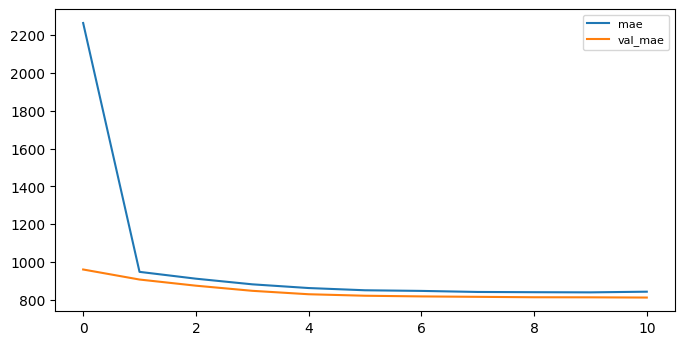

Mean average error ending value: training data 842.6 ; validation data 811.62
Lowest Mean average error on the validation data: 811.62
Lowest Mean average error as a % of average price:   20.6%


In [43]:
# parameters not specified use the default values
model = get_model(feature_columns_numerical, 
                  labels_numerical, 
                  train_ds, 
                  val_ds)

<div class="alert alert-block alert-info">
    With this initial approach, the best result for mean average error is approx. <b>21%</b> of the average price of a diamond. Now let us see what results we get when we use only the categorical features.
</div>

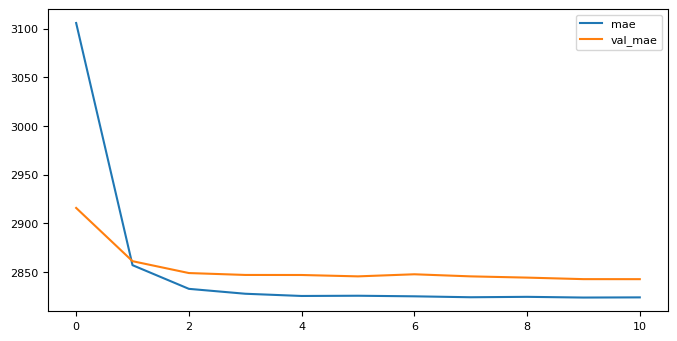

Mean average error ending value: training data 2823.85 ; validation data 2842.56
Lowest Mean average error on the validation data: 2842.56
Lowest Mean average error as a % of average price:   72.3%


In [44]:
model = get_model(feature_columns_categorical, 
                  labels_categorical, 
                  train_ds, 
                  val_ds, 
                  verbose=0)

<div class="alert alert-block alert-info">
We can see that the average error is very large and the categorical columns by themselves do not seem to have much predictive power. Let's now attempt the same thing with all columns
</div>

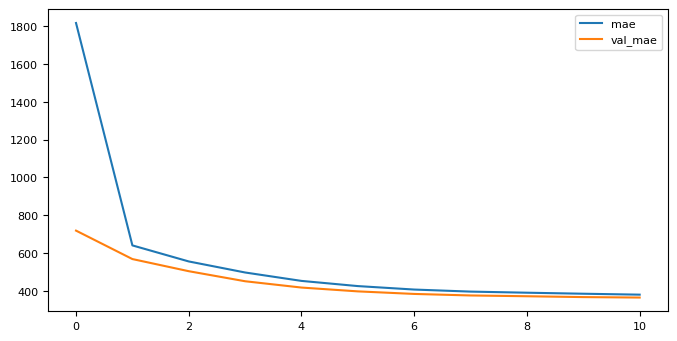

Mean average error ending value: training data 379.78 ; validation data 364.46
Lowest Mean average error on the validation data: 364.46
Lowest Mean average error as a % of average price:   9.3%


In [45]:
model = get_model(feature_columns_all, 
                  labels_all, 
                  train_ds, 
                  val_ds, 
                  verbose=0)

<div class="alert alert-block alert-info">
We can see that, using the combined columns, we get a much better prediction. The <b>mean average error</b> is now reduced to <b>9.3%</b> of the average price, which is <u>less than half</u> of what we had with the numerical columns alone.
We will proceed further with this last option, where we use all the columns. Let us now see which value for the batch size works best.
</div>

In [46]:
# different values of batch size, default values for the other tunable parameters
for bs in [16, 32, 64, 128, 256]:
    print('Processing model with batch size:', bs)
    model = get_model(feature_columns_all, 
                      labels_all, 
                      train_data, 
                      val_data, 
                      input_format='df',
                      batch_size=bs,
                      verbose=0, 
                      showchart=False)
    print('===================')

Processing model with batch size: 16
Mean average error ending value: training data 361.82 ; validation data 345.62
Lowest Mean average error on the validation data: 345.62
Lowest Mean average error as a % of average price:   8.8%
Processing model with batch size: 32
Mean average error ending value: training data 385.11 ; validation data 365.17
Lowest Mean average error on the validation data: 365.17
Lowest Mean average error as a % of average price:   9.3%
Processing model with batch size: 64
Mean average error ending value: training data 399.89 ; validation data 381.23
Lowest Mean average error on the validation data: 381.23
Lowest Mean average error as a % of average price:   9.7%
Processing model with batch size: 128
Mean average error ending value: training data 481.46 ; validation data 456.38
Lowest Mean average error on the validation data: 456.38
Lowest Mean average error as a % of average price:   11.6%
Processing model with batch size: 256
Mean average error ending value: tra

<div class="alert alert-block alert-info">
The results indicate that the use of small batch size may be appropriate, even with the extra computing time. We will choose a batch size of 16. <br/>
Now that we have decided on the optimal batch size, let's attempt a few different options with the number of units for the layers
</div>

In [47]:
# combinations of layer 2/3 units, batch size = 16, default values for the other tunable parameters
for (l2,l3) in {(64,0), (64,64), (128,0), (128, 64), (128, 128), (256, 128), (256, 256),(512, 256), (512, 512)}:
    print('Processing model with layer 2 units: ', l2, 'layer 3 units: ', l3)
    model = get_model(feature_columns_all, 
                      labels_all, 
                      train_data, 
                      val_data,
                      input_format='df',
                      layer2_units=l2, 
                      layer3_units=l3, 
                      batch_size=16,
                      verbose=0, 
                      showchart=False)
    print('===================')

Processing model with layer 2 units:  512 layer 3 units:  512
Mean average error ending value: training data 337.37 ; validation data 335.32
Lowest Mean average error on the validation data: 335.32
Lowest Mean average error as a % of average price:   8.5%
Processing model with layer 2 units:  128 layer 3 units:  0
Mean average error ending value: training data 572.52 ; validation data 547.51
Lowest Mean average error on the validation data: 547.51
Lowest Mean average error as a % of average price:   13.9%
Processing model with layer 2 units:  128 layer 3 units:  64
Mean average error ending value: training data 405.56 ; validation data 359.14
Lowest Mean average error on the validation data: 359.14
Lowest Mean average error as a % of average price:   9.1%
Processing model with layer 2 units:  64 layer 3 units:  0
Mean average error ending value: training data 623.91 ; validation data 589.32
Lowest Mean average error on the validation data: 589.32
Lowest Mean average error as a % of ave

<div class="alert alert-block alert-info">
The best combination seems to be (512, 512) <br/>
Let's also attempt a model with <b>adam</b> optimizer, using the best layer settings we have with rmsprop and the default parameters for adam. <br/>
The default parameters* are: learning_rate=0.001, beta_1=0.9, beta_2=0.999 <br/>
*source: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
</div>

In [48]:
model = get_model(feature_columns_all, 
                  labels_all, 
                  train_data, 
                  val_data, 
                  input_format='df',
                  batch_size=16,
                  layer2_units=512, 
                  layer3_units=512, 
                  verbose=0,
                  showchart=False,
                  optimizer='adam')

Mean average error ending value: training data 338.65 ; validation data 342.18
Lowest Mean average error on the validation data: 342.18
Lowest Mean average error as a % of average price:   8.7%


<div class="alert alert-block alert-info">
The <b>adam</b> optimizer doesn't seem to get to a better result with the same combination. However, let's see if we reach the same conclusion when we also optimize it. We start with the batch size.
</div>

In [49]:
# different values of batch size, default values for the other tunable parameters
for bs in [16, 32, 64, 128, 256]:
    print('Processing model with batch size:', bs)
    model = get_model(feature_columns_all, 
                      labels_all, 
                      train_data, 
                      val_data, 
                      input_format='df',
                      batch_size=bs,
                      verbose=0, 
                      showchart=False,
                      optimizer='adam')
    print('===================')

Processing model with batch size: 16
Mean average error ending value: training data 381.83 ; validation data 388.44
Lowest Mean average error on the validation data: 386.15
Lowest Mean average error as a % of average price:   9.8%
Processing model with batch size: 32
Mean average error ending value: training data 389.78 ; validation data 418.03
Lowest Mean average error on the validation data: 417.22
Lowest Mean average error as a % of average price:   10.6%
Processing model with batch size: 64
Mean average error ending value: training data 434.1 ; validation data 432.93
Lowest Mean average error on the validation data: 432.93
Lowest Mean average error as a % of average price:   11.0%
Processing model with batch size: 128
Mean average error ending value: training data 518.37 ; validation data 497.7
Lowest Mean average error on the validation data: 497.7
Lowest Mean average error as a % of average price:   12.7%
Processing model with batch size: 256
Mean average error ending value: trai

<div class="alert alert-block alert-info">
Best choice for batch size remains 16 for adam as well. We proceed with optimizing the layer units
</div>

In [50]:
# combinations of layer 2/3 units, batch_size = 16
for (l2,l3) in {(64,0), (64,64), (128,0), (128, 64), (128, 128), (256, 128), (256, 256),(512, 256), (512, 512)}:
    print('Processing model with layer 2 units: ', l2, 'layer 3 units: ', l3)
    model = get_model(feature_columns_all, 
                      labels_all, 
                      train_data, 
                      val_data,
                      input_format='df',
                      batch_size=16,
                      layer2_units=l2, 
                      layer3_units=l3,
                      verbose=0, 
                      showchart=False,
                      optimizer='adam')
    print('===================')

Processing model with layer 2 units:  512 layer 3 units:  512
Mean average error ending value: training data 339.04 ; validation data 341.26
Lowest Mean average error on the validation data: 341.26
Lowest Mean average error as a % of average price:   8.7%
Processing model with layer 2 units:  128 layer 3 units:  0
Mean average error ending value: training data 614.28 ; validation data 577.78
Lowest Mean average error on the validation data: 577.78
Lowest Mean average error as a % of average price:   14.7%
Processing model with layer 2 units:  128 layer 3 units:  64
Mean average error ending value: training data 408.53 ; validation data 400.25
Lowest Mean average error on the validation data: 400.25
Lowest Mean average error as a % of average price:   10.2%
Processing model with layer 2 units:  64 layer 3 units:  0
Mean average error ending value: training data 656.8 ; validation data 613.12
Lowest Mean average error on the validation data: 613.12
Lowest Mean average error as a % of ave

<div class="alert alert-block alert-info">
Best combination is (512, 512) Now we will also analyze different values for learning rates.
</div>

In [51]:
# layer 2 = 512, layer 3 = 512, batch_size = 16, various learning rates
learning_rates = [0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
for lr in learning_rates:
    print('Processing model with learning rate: ',lr)
    model = get_model(feature_columns_all, 
                      labels_all, 
                      train_data, 
                      val_data,
                      batch_size=16,
                      input_format='df',
                      layer2_units=512, 
                      layer3_units=512, 
                      learning_rate=lr,
                      verbose=0, 
                      showchart=False,
                      optimizer='adam')
    print('===================')

Processing model with learning rate:  0.01
Mean average error ending value: training data 348.08 ; validation data 352.04
Lowest Mean average error on the validation data: 337.25
Lowest Mean average error as a % of average price:   8.6%
Processing model with learning rate:  0.005
Mean average error ending value: training data 340.16 ; validation data 343.45
Lowest Mean average error on the validation data: 343.45
Lowest Mean average error as a % of average price:   8.7%
Processing model with learning rate:  0.0025
Mean average error ending value: training data 333.92 ; validation data 333.58
Lowest Mean average error on the validation data: 332.83
Lowest Mean average error as a % of average price:   8.5%
Processing model with learning rate:  0.001
Mean average error ending value: training data 338.34 ; validation data 345.27
Lowest Mean average error on the validation data: 345.27
Lowest Mean average error as a % of average price:   8.8%
Processing model with learning rate:  0.0005
Mea

<div class="alert alert-block alert-info">
    <b>Learning rate = 0.0025</b> produces the best results for adam and is now having a slightly better result than rmsprop. Let's compare both models, with their best settings but for more epochs.
</div>

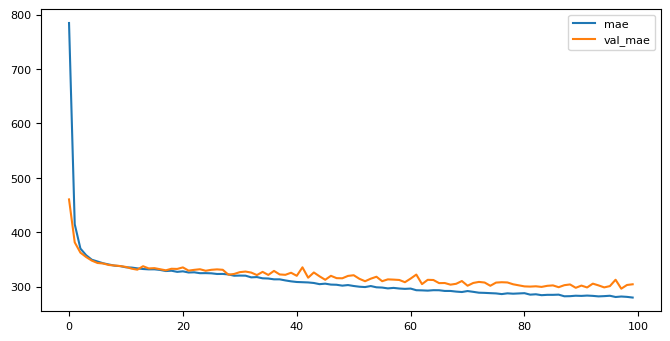

Mean average error ending value: training data 280.17 ; validation data 304.55
Lowest Mean average error on the validation data: 296.47
Lowest Mean average error as a % of average price:   7.5%


In [52]:
model = get_model(feature_columns_all, 
                  labels_all, 
                  train_data, 
                  val_data, 
                  input_format='df',
                  batch_size=16,
                  layer2_units=512, 
                  layer3_units=512, 
                  epochs=100,
                  verbose=0, 
                  showchart=True,
                  optimizer='rmsprop')

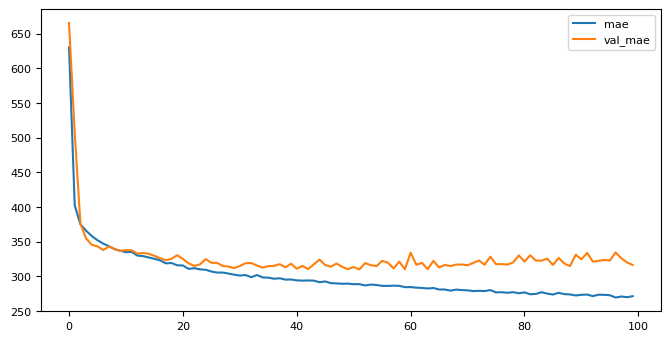

Mean average error ending value: training data 271.41 ; validation data 316.38
Lowest Mean average error on the validation data: 309.96
Lowest Mean average error as a % of average price:   7.9%


In [53]:
model = get_model(feature_columns_all, 
                  labels_all, 
                  train_data, 
                  val_data,
                  input_format='df',
                  batch_size=16,
                  layer2_units=512, 
                  layer3_units=512, 
                  epochs=100,
                  learning_rate=0.0025,
                  verbose=0, 
                  showchart=True,
                  optimizer='adam')

<h3>Results</h3>

<div class="alert alert-block alert-info">
The lowest result is for rmsprop on the validation data. However, adam seems to do a better job at training and gets to comparable results faster, after approx 50 epochs, after which learning stops. The risk of overtraining is therefore lower with adam.
We'll be choosing as a final set of parameters the following: <br/>
<li>optimizer='adam'</li>
<li>learning rate=0.0025</li>
<li>layer2 units=512</li>
<li>layer3 units=512</li>
<li>epochs=50</li><br/>
Now let's train on the entire training & validation dataset and use the testing partition for the final evaluation:
</div>

In [54]:
# normalize data and convert to tensorflow datasets
for column in labels_numerical:
    train_val_data[column] = normalize(train_val_data, mean_dict, std_dict, column)
    test_data[column] = normalize(test_data, mean_dict, std_dict, column)

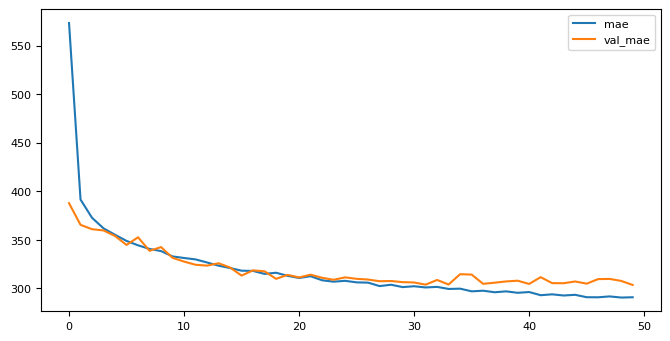

Mean average error ending value: training data 290.88 ; validation data 303.55
Lowest Mean average error on the validation data: 303.55
Lowest Mean average error as a % of average price:   7.7%


In [56]:
# train model on training + validation data and evaluate on the test data
# use the best parameters we obtained through tuning
model = get_model(feature_columns_all, 
                  labels_all, 
                  train_val_data, 
                  test_data, 
                  input_format='df',
                  batch_size=16,
                  layer2_units=512, 
                  layer3_units=512,
                  learning_rate=0.0025,
                  epochs=50,
                  verbose=0,
                  optimizer="adam")

<div class="alert alert-block alert-info">
We will first build a function to help us tabulate all the results of the model combinations we attempted
</div>

In [57]:
# function to generate markdown code for results table
def print_results(input_results):
    """generate markdown code for a matrix and display
    """
    table = '| Features Used | Batch Size | Optimizer | Layer 2 units |  Layer 3 units  | Learning rate | Epochs | Min MAE |'
    table += '\n'
    table += '| --- | --- | --- | --- | --- | --- | --- | --- |'
    for i in range (0, len(input_results)):
        table += '\n' + '|'
        table += (str(input_results[i]['features_used']) + '|')
        table += (str(input_results[i]['batch_size']) + '|')
        table += (str(input_results[i]['optimizer']) + '|')
        table += (str(input_results[i]['layer2_units']) + '|')
        table += (str(input_results[i]['layer3_units']) + '|')
        table += (str(input_results[i]['learning_rate']) + '|')
        table += (str(input_results[i]['epochs']) + '|')
        table += (str(input_results[i]['min_mae_val_data']) + '|')
    table += '\n'
    display(md(table))
    display(md('***'))

<div class="alert alert-block alert-info">
Below is a summary of all the combinations we attempted throughout the analysis:
</div>

In [58]:
print_results(results)

| Features Used | Batch Size | Optimizer | Layer 2 units |  Layer 3 units  | Learning rate | Epochs | Min MAE |
| --- | --- | --- | --- | --- | --- | --- | --- |
|6|32|rmsprop|128|128|0.001|11|811.62|
|3|32|rmsprop|128|128|0.001|11|2842.56|
|9|32|rmsprop|128|128|0.001|11|364.46|
|9|16|rmsprop|128|128|0.001|11|345.62|
|9|32|rmsprop|128|128|0.001|11|365.17|
|9|64|rmsprop|128|128|0.001|11|381.23|
|9|128|rmsprop|128|128|0.001|11|456.38|
|9|256|rmsprop|128|128|0.001|11|551.91|
|9|16|rmsprop|512|512|0.001|11|335.32|
|9|16|rmsprop|128|0|0.001|11|547.51|
|9|16|rmsprop|128|64|0.001|11|359.14|
|9|16|rmsprop|64|0|0.001|11|589.32|
|9|16|rmsprop|128|128|0.001|11|344.18|
|9|16|rmsprop|64|64|0.001|11|362.81|
|9|16|rmsprop|512|256|0.001|11|336.42|
|9|16|rmsprop|256|128|0.001|11|340.34|
|9|16|rmsprop|256|256|0.001|11|338.96|
|9|16|adam|512|512|0.001|11|342.18|
|9|16|adam|128|128|0.001|11|386.15|
|9|32|adam|128|128|0.001|11|417.22|
|9|64|adam|128|128|0.001|11|432.93|
|9|128|adam|128|128|0.001|11|497.7|
|9|256|adam|128|128|0.001|11|574.52|
|9|16|adam|512|512|0.001|11|341.26|
|9|16|adam|128|0|0.001|11|577.78|
|9|16|adam|128|64|0.001|11|400.25|
|9|16|adam|64|0|0.001|11|613.12|
|9|16|adam|128|128|0.001|11|383.86|
|9|16|adam|64|64|0.001|11|406.39|
|9|16|adam|512|256|0.001|11|350.46|
|9|16|adam|256|128|0.001|11|366.8|
|9|16|adam|256|256|0.001|11|350.21|
|9|16|adam|512|512|0.01|11|337.25|
|9|16|adam|512|512|0.005|11|343.45|
|9|16|adam|512|512|0.0025|11|332.83|
|9|16|adam|512|512|0.001|11|345.27|
|9|16|adam|512|512|0.0005|11|359.84|
|9|16|adam|512|512|0.00025|11|409.02|
|9|16|adam|512|512|0.0001|11|482.66|
|9|16|rmsprop|512|512|0.001|100|296.47|
|9|16|adam|512|512|0.0025|100|309.96|
|9|16|adam|512|512|0.0025|50|303.55|


***

<h3>Conclusions</h3>

<div class="alert alert-block alert-info">
The results we obtained on the validation data with our model are also reflected when we evaluate on the testing data so we can consider the methodology to be correct. The main conclusions from our attempts are the following:

<li><b>feature_layer</b> module is a great tool, especially because of how easy it makes the use of multiple types of features in a linear regression model </li>
<li>The combination of all the features has the highest predictive power for the price of a diamond. </li>
<li>The number of layers used in the model and the units for each layer also influences the results significantly, with higher values producing a better result.</li>
<li>adam optimizer produces slighly better results than rmsprop for this dataset, if we tune the learning rate.</li>
<li>The batch size is normally at least 32 but, for this dataset, the additional processing required by a batch size of 16 seems to have a significant contribution.</li>
<li>The number of epochs used in learning is also essential, but after exceeding 50 epochs for adam optimizer, it doesn't seem to make a difference and leads to over-training.</li>
<br/>
The model can be further improved by using other optimizers or by further tuning of other parameters of <b>rmsprop</b> and <b>adam</b>. Reducing the batch size may also improve the results.
</div>